In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import ipaddress

In [3]:
DATADIR = '/home/infres/abiapo/prim/data'

In [4]:
data = pd.read_csv(DATADIR+'/balance_mix_data.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,112140,172.16.0.5-192.168.50.1-44231-8387-17,172.16.0.5,44231,192.168.50.1,8387,17,2018-12-01 13:45:46.994571,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
1,25309,172.16.0.5-192.168.50.1-891-63192-17,172.16.0.5,891,192.168.50.1,63192,17,2018-12-01 12:14:48.493601,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_SNMP,1
2,3538,172.16.0.5-192.168.50.1-649-33920-17,172.16.0.5,649,192.168.50.1,33920,17,2018-12-01 10:36:57.214865,1620,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NTP,1
3,11531,192.168.10.50-192.168.50.6-22-56370-6,192.168.50.6,56370,192.168.10.50,22,6,2018-11-03 12:46:39.696861,8996366,6,...,2995940.0,2995940.0,6000423.0,0.0,6000423.0,6000423.0,0,1,BENIGN,0
4,1489,192.168.50.6-4.2.2.4-58840-53-17,192.168.50.6,58840,4.2.2.4,53,17,2018-12-01 10:59:03.241570,20681,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0


In [5]:
data = data.drop(['Unnamed:_0'],axis=1)
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))

In [6]:
data = data.drop(['Flow_ID'],axis=1)
data = data.drop(['Timestamp'],axis=1)
data = data.drop(['SimillarHTTP'],axis=1)

In [7]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [8]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [24]:
col2drop = X.iloc[:,[35,36,37,47,50,54,60,61,62,63,64,65]].columns.to_list()
X = X.drop(col2drop,axis=1)

In [20]:
col2drop

['Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'FIN_Flag_Count',
 'PSH_Flag_Count',
 'ECE_Flag_Count',
 'Fwd_Avg_Bytes_Bulk',
 'Fwd_Avg_Packets_Bulk',
 'Fwd_Avg_Bulk_Rate',
 'Bwd_Avg_Bytes_Bulk',
 'Bwd_Avg_Packets_Bulk',
 'Bwd_Avg_Bulk_Rate']

In [25]:
X.head()

,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Inbound
1,2886729733,891,3232248321,63192,17,2,2,0,2944.0,0.0,...,-1062718975,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1
2,2886729733,649,3232248321,33920,17,1620,126,0,55440.0,0.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1
3,3232248326,56370,3232238130,22,6,8996366,6,0,0.0,0.0,...,28,2995940.0,0.000000,2995940.0,2995940.0,6000423.0,0.000000,6000423.0,6000423.0,1
4,3232248326,58840,67240452,53,17,20681,2,2,50.0,212.0,...,20,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
5,3232248326,58424,2899905058,443,6,116830838,28,19,3860.0,6402.0,...,20,122927.5,85854.784051,183636.0,62219.0,58261342.0,323755.910834,58490272.0,58032412.0,0


# Feature selection

In [8]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel

In [9]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

/home/infres/abiapo/prim_ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [35 36 37 47 50 54 60 61 62 63 64 65] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/infres/abiapo/prim_ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.head()

,Specs,Score
0,Source_IP,3088.218495
1,Source_Port,14484.364758
2,Destination_IP,131892.416410
3,Destination_Port,69646.428307
4,Protocol,116197.690449


In [11]:
preselect_feature = featureScores.nlargest(20,'Score')['Specs'].to_list()

## Feature Importance Method

### Extra Tree Classifier 

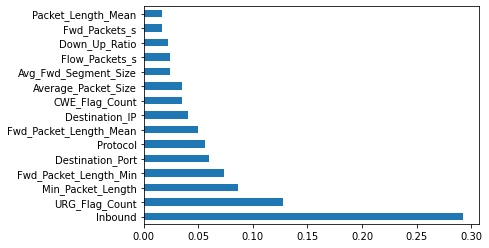

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X[preselect_feature],y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X[preselect_feature].columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [13]:
feature_selected = feat_importances.nlargest(15).index.to_list()

In [24]:
feature_selected

['Inbound',
 'URG_Flag_Count',
 'Min_Packet_Length',
 'Destination_Port',
 'Fwd_Packet_Length_Min',
 'Protocol',
 'Destination_IP',
 'Avg_Fwd_Segment_Size',
 'CWE_Flag_Count',
 'Fwd_Packet_Length_Mean',
 'Average_Packet_Size',
 'Packet_Length_Mean',
 'Flow_Bytes_s',
 'Fwd_Packets_s',
 'Flow_Packets_s']

## Models

In [14]:
def cal_accuracy(y_test, y_pred): 
    print("Confusion Matrix: ")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
    print("Report : ", classification_report(y_test, y_pred))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_selected], y, test_size = 0.3, random_state = 42)   

In [29]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_sc = std_scaler.transform(X_train)
X_test_sc = std_scaler.transform(X_test)

#### Decision Tree

Confusion Matrix: 
Accuracy :  99.96119277875228
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32559
           1       1.00      1.00      1.00     31862

    accuracy                           1.00     64421
   macro avg       1.00      1.00      1.00     64421
weighted avg       1.00      1.00      1.00     64421



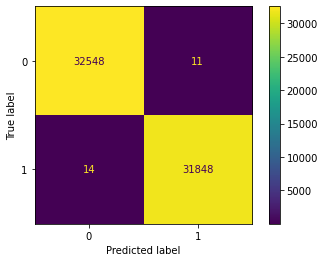

In [16]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_entropy.fit(X_train, y_train) 
y_pred_entropy = clf_entropy.predict(X_test)
cal_accuracy(y_test, y_pred_entropy)

#### Naive Bayes

-----------Naive Bayes----------
Confusion Matrix: 
Accuracy :  90.3727045528632
Report :                precision    recall  f1-score   support

           0       1.00      0.81      0.89     32559
           1       0.84      1.00      0.91     31862

    accuracy                           0.90     64421
   macro avg       0.92      0.90      0.90     64421
weighted avg       0.92      0.90      0.90     64421



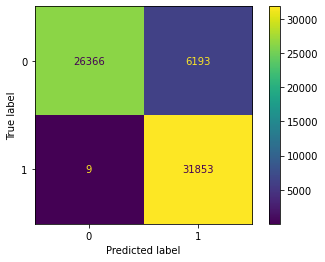

In [17]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred_nb = gnb.predict(X_test)
cal_accuracy(y_test, y_pred_nb)

#### Logistic Regression

-----------Logistic Regression----------
Confusion Matrix: 
Accuracy :  74.83118858757237
Report :                precision    recall  f1-score   support

           0       0.71      0.84      0.77     32559
           1       0.80      0.65      0.72     31862

    accuracy                           0.75     64421
   macro avg       0.76      0.75      0.75     64421
weighted avg       0.76      0.75      0.75     64421



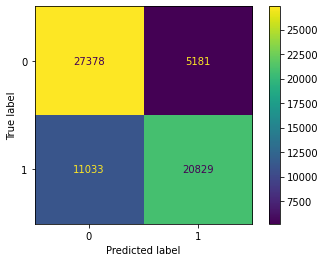

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state = 0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
cal_accuracy(y_test, y_pred_lr)

#### Support Vector Machine with polynomial kernel

-----------Support Vector Machine----------
Confusion Matrix: 
Accuracy :  87.30227720774282
Report :                precision    recall  f1-score   support

           0       1.00      0.75      0.86     32559
           1       0.80      1.00      0.89     31862

    accuracy                           0.87     64421
   macro avg       0.90      0.87      0.87     64421
weighted avg       0.90      0.87      0.87     64421



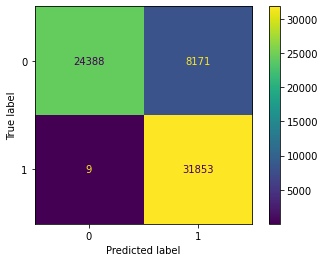

In [19]:
print("-----------Support Vector Machine----------")
from sklearn.svm import SVC
clf = SVC(kernel = 'poly', random_state = 0)
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
cal_accuracy(y_test, y_pred_svc)

#### Support Vector Machine with gaussian kernel

-----------Support Vector Machine----------
Confusion Matrix: 
Accuracy :  89.31249126837521
Report :                precision    recall  f1-score   support

           0       1.00      0.79      0.88     32559
           1       0.82      1.00      0.90     31862

    accuracy                           0.89     64421
   macro avg       0.91      0.89      0.89     64421
weighted avg       0.91      0.89      0.89     64421



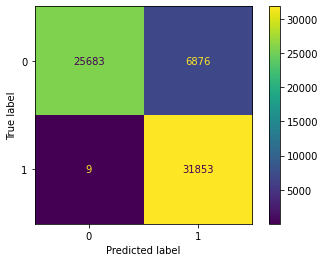

In [20]:
from sklearn.svm import SVC
clf = SVC(kernel = 'rbf', random_state = 0)
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
cal_accuracy(y_test, y_pred_svc)

#### K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cal_accuracy(y_test, y_pred_knn)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rndForest =RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rndForest.fit(X_train,y_train)
y_pred_rf = rndForest.predict(X_test)
cal_accuracy(y_test, y_pred_rf)

To choose a value of $k$ we must compare the performance of the model with classification report of serveral techniques. Now we focus on the different selection techniques

### RandomForest Classifier

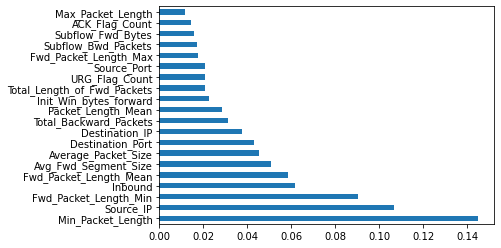

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [34]:
feature_selected = feat_importances.nlargest(20).index.to_list()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_selected], y, test_size = 0.3, random_state = 42)   

In [40]:
X_train

,Min_Packet_Length,Source_IP,Fwd_Packet_Length_Min,Inbound,Fwd_Packet_Length_Mean,Avg_Fwd_Segment_Size,Average_Packet_Size,Destination_Port,Destination_IP,Total_Backward_Packets,Packet_Length_Mean,Init_Win_bytes_forward,Total_Length_of_Fwd_Packets,URG_Flag_Count,Source_Port,Fwd_Packet_Length_Max,Subflow_Bwd_Packets,Subflow_Fwd_Bytes,ACK_Flag_Count,Max_Packet_Length
201254,0.0,3232248327,0.0,0,70.294118,70.294118,175.565217,443,2899905250,35,173.057143,64240,2390.0,0,52852,517.0,35,2390,1,2860.0
35156,0.0,3232248573,0.0,0,0.000000,0.000000,0.000000,0,3758096389,0,0.000000,-1,0.0,0,0,0.0,0,0,0,0.0
60005,0.0,3232248326,0.0,0,148.500000,148.500000,207.375000,80,2100873577,4,184.333333,255,594.0,1,58160,297.0,4,594,0,384.0
89133,0.0,3232248326,0.0,0,227.200000,227.200000,447.172414,443,2637688958,14,432.266667,8192,3408.0,0,56818,805.0,14,3408,1,1460.0
150182,47.0,3232248328,47.0,0,47.000000,47.000000,101.250000,53,67240452,2,81.000000,-1,94.0,0,61560,47.0,2,94,0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121999,229.0,2886729733,229.0,1,229.000000,229.000000,343.500000,9913,3232248321,0,229.000000,-1,458.0,0,638,229.0,0,458,0,229.0
105534,32.0,3232248328,32.0,0,32.000000,32.000000,88.000000,53,67240452,2,70.400000,-1,64.0,0,54418,32.0,2,64,0,128.0
134275,0.0,2899902566,0.0,1,25.333333,25.333333,22.800000,59152,3232248328,2,19.000000,246,76.0,1,443,38.0,2,76,0,38.0
149486,401.0,2886729733,401.0,1,401.000000,401.000000,601.500000,15561,3232248321,0,401.000000,-1,802.0,0,35928,401.0,0,802,0,401.0


 ## Decision Tree

Confusion Matrix: 
Accuracy :  99.96274506760217
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32559
           1       1.00      1.00      1.00     31862

    accuracy                           1.00     64421
   macro avg       1.00      1.00      1.00     64421
weighted avg       1.00      1.00      1.00     64421



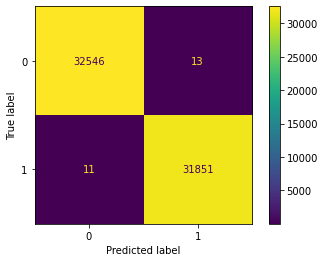

In [31]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_entropy.fit(X_train, y_train) 
y_pred_entropy = clf_entropy.predict(X_test)
cal_accuracy(y_test, y_pred_entropy)

## Naive Bayesian

-----------Naive Bayes----------
Confusion Matrix: 
Accuracy :  96.17981714037349
Report :                precision    recall  f1-score   support

           0       1.00      0.92      0.96     32559
           1       0.93      1.00      0.96     31862

    accuracy                           0.96     64421
   macro avg       0.96      0.96      0.96     64421
weighted avg       0.96      0.96      0.96     64421



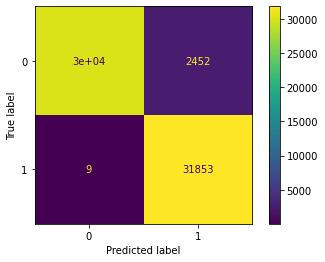

In [37]:
#Naive Bayes
print("-----------Naive Bayes----------")
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred_nb = gnb.predict(X_test)
cal_accuracy(y_test, y_pred_nb)

## Logistic Regression

-----------Logistic Regression----------
Confusion Matrix: 
Accuracy :  77.16427872898589
Report :                precision    recall  f1-score   support

           0       1.00      0.55      0.71     32559
           1       0.68      1.00      0.81     31862

    accuracy                           0.77     64421
   macro avg       0.84      0.77      0.76     64421
weighted avg       0.84      0.77      0.76     64421



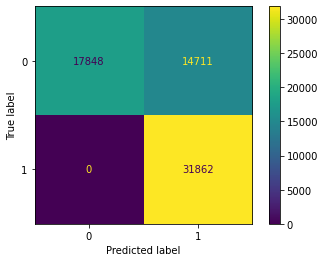

In [39]:
#Logistic Regression
print("-----------Logistic Regression----------")
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state = 0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
cal_accuracy(y_test, y_pred_lr)

## SVM

-----------Support Vector Machine----------
Confusion Matrix: 
Accuracy :  95.51233293491252
Report :                precision    recall  f1-score   support

           0       1.00      0.91      0.95     32559
           1       0.92      1.00      0.96     31862

    accuracy                           0.96     64421
   macro avg       0.96      0.96      0.96     64421
weighted avg       0.96      0.96      0.96     64421



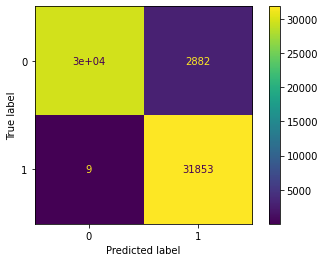

In [41]:
#Support Vector Machine
print("-----------Support Vector Machine----------")
from sklearn.svm import SVC
clf = SVC(kernel = 'poly', random_state = 0)
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
cal_accuracy(y_test, y_pred_svc)